<a href="https://colab.research.google.com/github/jrleonett/SwinIR/blob/main/SwinIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 'SwinIR: Restauración de imágenes usando Swin Transformer''.
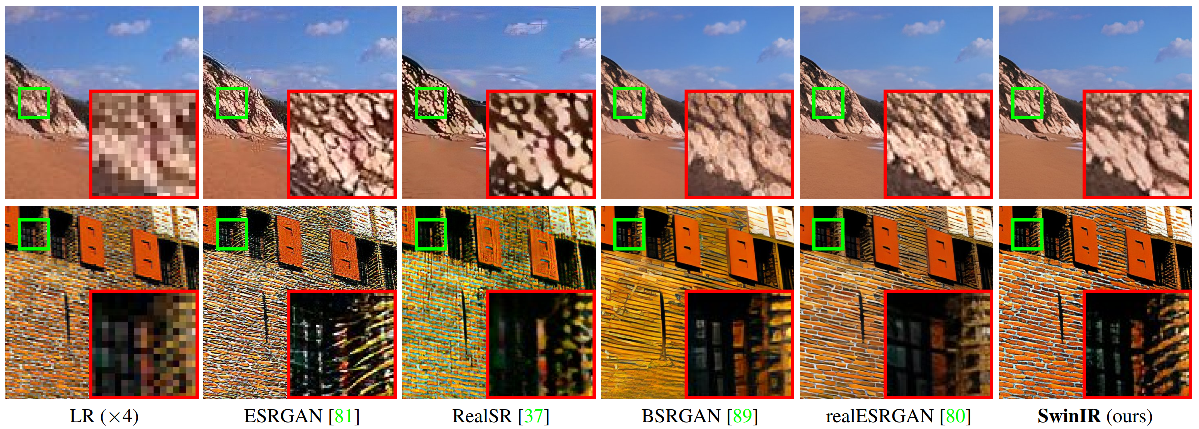

In [ ]:
#@title #**1.) Instalación y configuración**

# Clonar realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Configurar el entorno
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clonar BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

!rm -r SwinIR
# Clonar SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Descarga los modelos pre-entrenados
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

In [ ]:
#@title #**2.) Cargar imagen a procesar**
# Sube las imágenes para ser procesadas por SwinIR

import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)


In [ ]:
#@title #**3.) Analizando y procesando los datos basado en los modelos-precargados**

# BSRGAN
!rm -r results
if not test_patch_wise:
  %cd BSRGAN
  !python main_test_bsrgan.py
  %cd ..
  shutil.move('BSRGAN/testsets/RealSRSet_results_x4', 'results/BSRGAN')

# realESRGAN
if test_patch_wise:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --tile 800
else:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN

# SwinIR
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --tile 800
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR')

# SwinIR-Largo
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # aquí hay un error en la descarga de archivos de Colab: no hay archivos con el mismo nombre

In [ ]:
#@title #**4.) Visualización de Resultados**

# útiles para la visualización
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title('Input image', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('BSRGAN (ICCV2021) output', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title('Real-ESRGAN output', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title('SwinIR (ours) output', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title('SwinIR-Large (ours) output', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2['BSRGAN'])
  ax3.imshow(img2['realESRGAN'])
  ax4.imshow(img2['SwinIR'])
  ax5.imshow(img2['SwinIR-L'])

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Mostrar cada imagen en la carpeta de carga
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')
input_folder = upload_folder
result_folder = 'results/SwinIR'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = {}
  img_output['SwinIR'] = imread(output_path)
  img_output['SwinIR-L'] = imread(output_path.replace('SwinIR/', 'SwinIR_large/').replace('SwinIR.png', 'SwinIR_large.png'))
  if test_patch_wise:
    img_output['BSRGAN'] = img_output['SwinIR']*0+255
  else:
    img_output['BSRGAN'] = imread(output_path.replace('SwinIR', 'BSRGAN'))
  path = output_path.replace('/SwinIR/', '/realESRGAN/').replace('_SwinIR.png','_out{}'.format(os.path.splitext(input_path)[1]))
  if os.path.exists(path):
    shutil.move(path, path.replace('_out.', '_realESRGAN.'))
  img_output['realESRGAN'] = imread(path.replace('_out.', '_realESRGAN.'))

  display(img_input, img_output)

In [ ]:
#@title #5) Descarga los resultados

zip_filename = 'SwinIR_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)